In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

sys.path.insert(0, "../src/")
sys.path.insert(0, "../../project_1/src")
from NeuralNetwork import *
from CostFunctions import *
from ActivationFunctions import *
from SGD import *
from sklearn.model_selection import train_test_split
from FrankeFunction import *
from linear_regression import *
from stat_tools import *

## Notes
https://scikit-learn.org/stable/modules/neural_networks_supervised.html#tips-on-practical-use

- Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0, 1] or [-1, +1], or standardize it to have mean 0 and variance 1. Note that you must apply the same scaling to the test set for meaningful results. You can use StandardScaler for standardization.

In [2]:
#np.random.seed(2020)
N = 1000

xy = np.random.uniform(0, 1, (N, 2))
z = FrankeFunction(xy[:, 0], xy[:, 1]) +  np.random.normal(0, 1, N) * 0.2
z = z.reshape(-1,1)

xy_train, xy_test, z_train, z_test = train_test_split(xy, z, test_size=0.2)

# Rescale & center data wrt. training data
#z_train_intercept = np.mean(z_train)
#z_train -= z_train_intercept
#z_test -= z_train_intercept

#scaler = StandardScaler()
#scaler.fit(xy_train)
#xy_train = scaler.transform(xy_train)
#xy_test = scaler.transform(xy_test)

In [3]:
per_loop = 100
tot_epochs = 2_000
num_loops = int(tot_epochs / per_loop)

NN_MSE = np.empty(num_loops)
NN_epochs = np.empty(num_loops)

FFNN = FeedForwardNeuralNetwork(
    X=xy_train,
    Y=z_train,
    cost=CostFunctions.SquareError,
    activation=ActivationFunctions.ELU,
    activation_out=ActivationFunctions.ID,
    network_shape=[30],
)

for i in range(num_loops):
    FFNN.train(N_minibatches=int(N/32), learning_rate=0.01, n_epochs=per_loop)
    NN_MSE[i] = MSE(z_test, FFNN.predict(xy_test))
    NN_epochs[i] = FFNN.total_epochs


In [4]:
skl_model = MLPRegressor(
    hidden_layer_sizes = [30],
    activation = 'relu',
    solver = 'sgd',
    batch_size = 32,
    learning_rate_init = 0.1,
    max_iter = 1_000,
    tol=1e-6,
    momentum = 0,
    early_stopping = False
)
skl_model.fit(xy_train, z_train.flatten())

MLPRegressor(batch_size=32, hidden_layer_sizes=[30], learning_rate_init=0.1,
             max_iter=1000, momentum=0, solver='sgd', tol=1e-06)

In [5]:
print("Outgoing activation: ",skl_model.out_activation_)
print("No. Itterations: ", skl_model.n_iter_)

Outgoing activation:  identity
No. Itterations:  125


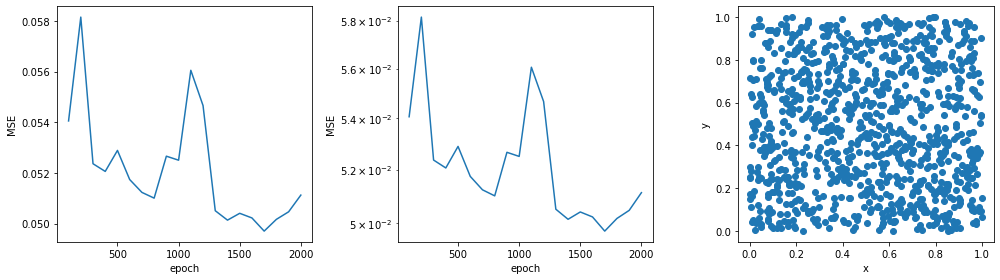

In [6]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.plot(NN_epochs, NN_MSE)
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.subplot(132)
plt.semilogy(NN_epochs, NN_MSE)
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.subplot(133)
plt.scatter(xy[:, 0], xy[:, 1])
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()

In [7]:
FFNN.train(N_minibatches=int(500/32), learning_rate=0.01, n_epochs=per_loop)
print(FFNN.total_epochs)# Predict using our class
resolution = 100
x = np.linspace(0, 1, resolution)
y = np.linspace(0, 1, resolution)
X, Y = np.meshgrid(x, y)
X_flat, Y_flat = X.flatten(), Y.flatten()
XY_flat = np.array([X_flat, Y_flat]).T
#XY_flat_scaled = scaler.fit(XY_flat)
Z_pred = FFNN.predict(XY_flat)
Z_pred = Z_pred.T.reshape(X.shape) # + z_train_intercept
Z_Franke = FrankeFunction(X, Y)

2100


In [8]:
# Predict using Scikit
z_skl_pred = skl_model.predict(XY_flat)
z_skl_pred = z_skl_pred.T.reshape(X.shape)

12100


Text(0.5, 0.92, 'SKLearn')

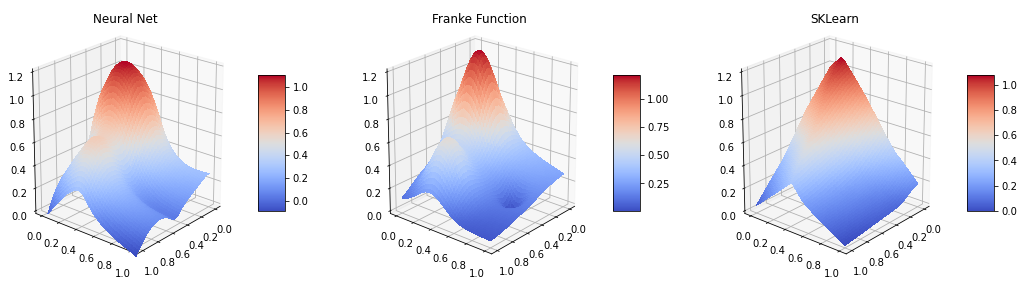

In [26]:
FFNN.train(N_minibatches=int(N/32), learning_rate=0.1, n_epochs=1_000)
print(FFNN.total_epochs)# Predict using our class
resolution = 100
x = np.linspace(0, 1, resolution)
y = np.linspace(0, 1, resolution)
X, Y = np.meshgrid(x, y)
X_flat, Y_flat = X.flatten(), Y.flatten()
XY_flat = np.array([X_flat, Y_flat]).T
#XY_flat_scaled = scaler.fit(XY_flat)
Z_pred = FFNN.predict(XY_flat)
Z_pred = Z_pred.T.reshape(X.shape) # + z_train_intercept
Z_Franke = FrankeFunction(X, Y)

elev = 20
azim = 40

fig = plt.figure(figsize=(18, 5))

ax = fig.add_subplot(1, 3, 1, projection="3d")
surf = ax.plot_surface(X, Y, Z_pred, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(elev=elev, azim=azim)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_zlim([0, 1.2])
ax.set_title("Neural Net")

ax = fig.add_subplot(1, 3, 2, projection="3d")
surf = ax.plot_surface(X, Y, Z_Franke, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(elev=elev, azim=azim)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_zlim([0, 1.2])
ax.set_title("Franke Function")

ax = fig.add_subplot(1, 3, 3, projection="3d")
surf = ax.plot_surface(X, Y, z_skl_pred, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(elev=elev, azim=azim)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_zlim([0, 1.2])
ax.set_title("SKLearn")

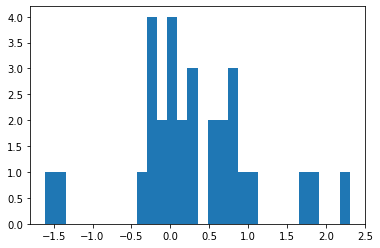

In [23]:
plt.hist(FFNN.biases[0], bins=30)
plt.show()